## BIOS 470/570 Lecture 12

## Last time we covered:
* ### Introduction to scanpy:
  - #### data preprocessing
  - #### dimensionality reduction
  - #### plotting

## Today we will cover:
* ### Clustering single cell data
* ### controlling for unwanted sources of variability
  - #### regress_out function
* ### combining single cell datasets

In [34]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Read the data

In [35]:
adata = sc.read_10x_h5('data/GSE182057_RAW'+'/GSM5517031_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique() #make the names unique (adds "-1" or similar)

### Add the cell labels from the paper:

In [36]:
labels = pd.read_csv('data/GSE182057_RAW'+'/clusters_wcellid.csv')
labels.index = labels.loc[:,"Unnamed: 0"]
adata.obs["label"] = labels["cluster"]

### For simplicity, we will skip the cell filtering and rely on that of the authors by dropping everything without a label:

In [37]:
adata = adata[adata.obs.dropna().index]

### Normalize the data, take the log, and restrict to highly variable genes:

In [38]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata #set the raw data to the filtered, logarithimized data.
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata = adata[:,adata.var.highly_variable]

### Let's look at whats in adata now:

In [39]:
adata

View of AnnData object with n_obs × n_vars = 4095 × 3000
    obs: 'label'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### One of the most common clustering algorithms for single cell data is the Leiden algorithm. It takes a parameter called resolution, which determines how finely the data is clustered. The neighbors function must be run first, and pca should be run before neighbors so this can be run on the pca space:

In [40]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)

In [41]:
sc.tl.leiden(adata,resolution=1) 
adata

AnnData object with n_obs × n_vars = 4095 × 3000
    obs: 'label', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

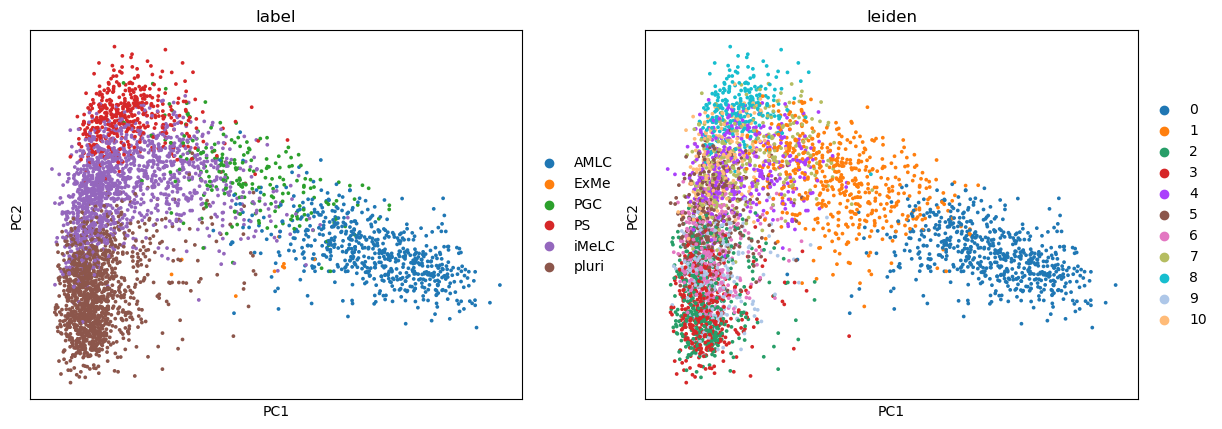

In [42]:
sc.pl.pca(adata,color = ["label","leiden"])

### Looks like the clustering algorithm made more clusters than the previous annotation. Let's reduce the resolution and see if they agree more closely:

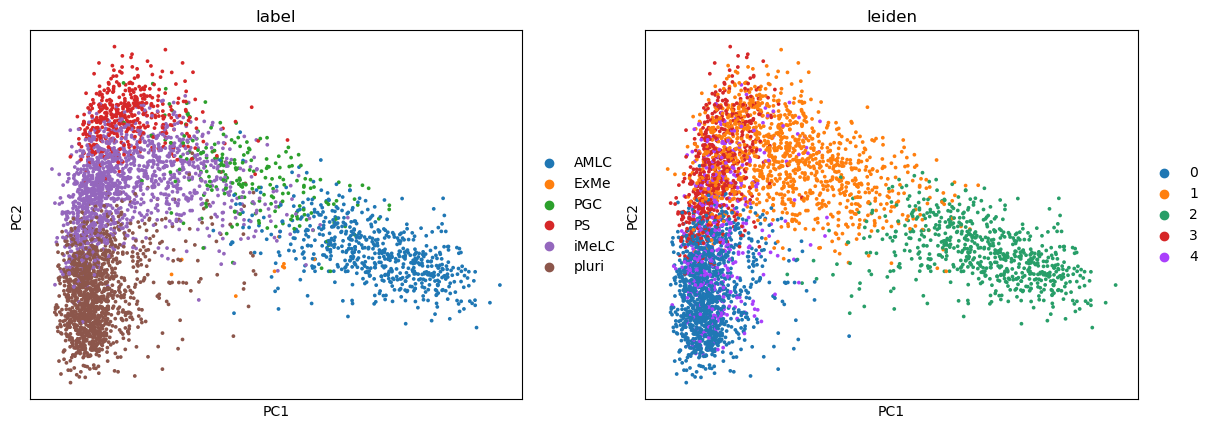

In [47]:
sc.tl.leiden(adata,resolution=0.4)
sc.pl.pca(adata,color = ["label","leiden"])

### Let's see how this looks in the UMAP space:

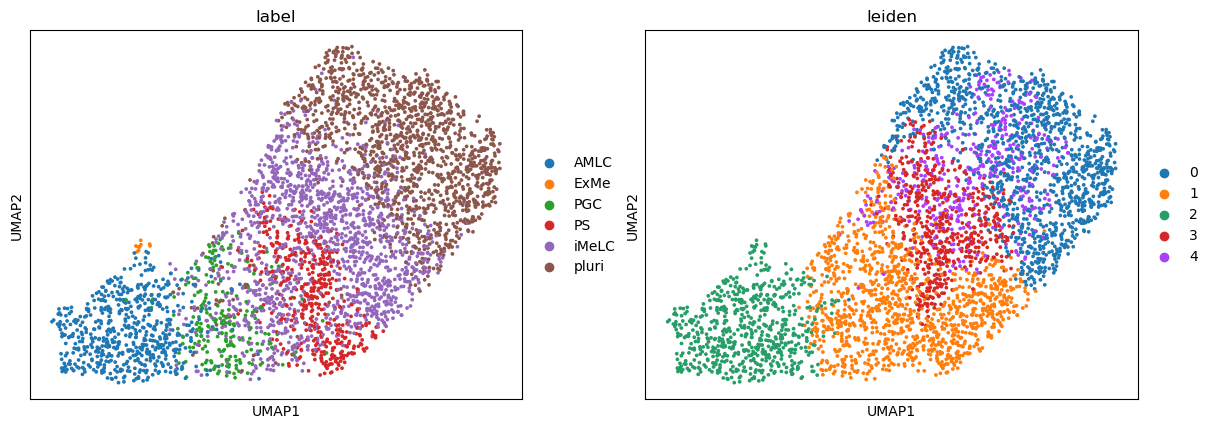

In [48]:
sc.tl.umap(adata)
sc.pl.umap(adata,color = ["label","leiden"])

### Removing unwanted variability example 1, cell cycle:

### Cells will be in different cell cycle phases which will create variability. In many studies, this variability can be a confounding factor. 

### The following uses a set of cell cycle genes where the first 43 lines are expressed in S-phase and the remaining aremexpressed in g2 or m. 

In [62]:
cell_cycle_genes = [x.strip() for x in open( '/Users/aw21/Github/scRNASeqWarmflash/scGenes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

### This assigns scores and a phase to each cell:

In [53]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata

AnnData object with n_obs × n_vars = 4095 × 3000
    obs: 'label', 'leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'label_colors', 'leiden_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Notice the variables that have been added to .obs: S_score, G2M_score, and phase. Let's see how these look in the UMAP space:

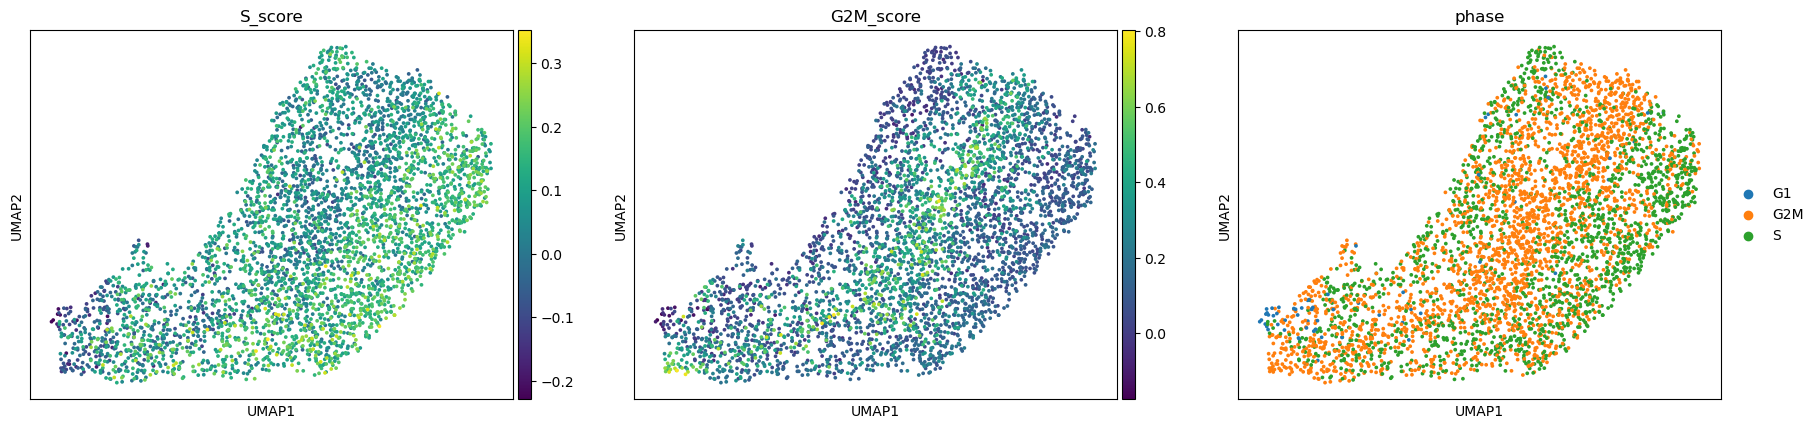

In [54]:
sc.pl.umap(adata,color = ['S_score','G2M_score','phase'])

### There is some structure to this - the G2M cells aare largely found in a stripe in the middle of this space, which indicates that the cell cycle is a significant source of variation between the cells. scanpy has a regress out feature to remove this variation. This is a linear correction to the data:

In [57]:
sc.pp.regress_out(adata,["G2M_score","S_score"])

### We need to rerun some of the analysis to see the effects of this: the neighbors (and the pca which it relies on) and the umap. We then plot the new umap:

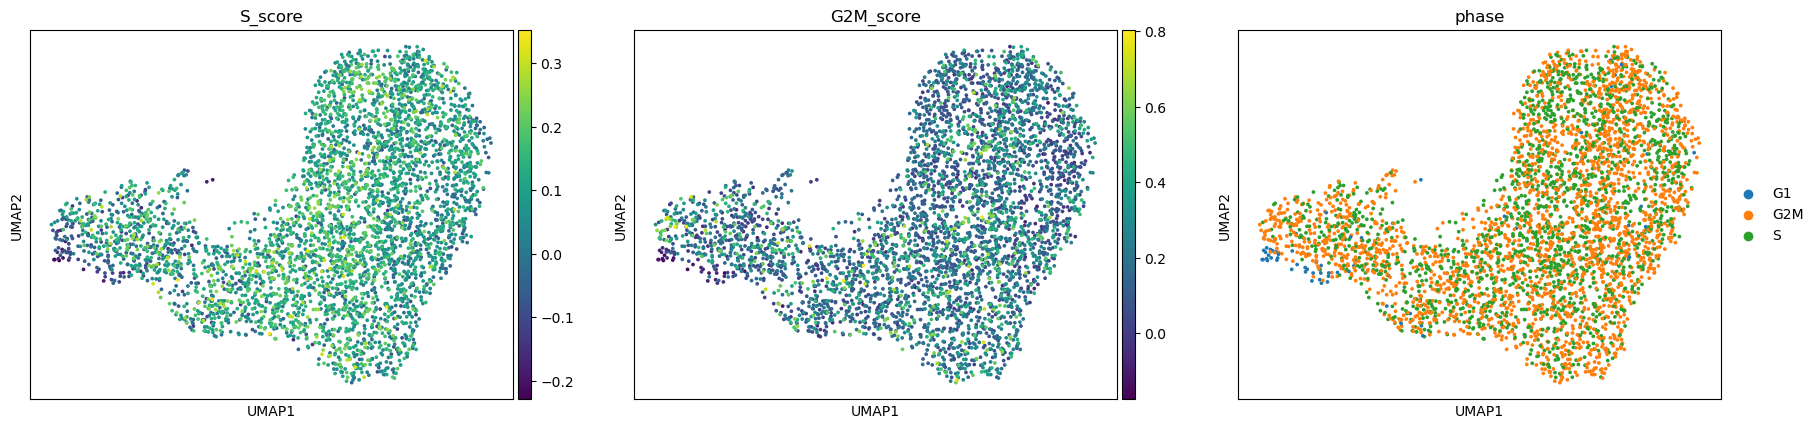

In [61]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata) 
sc.pl.umap(adata,color = ['S_score','G2M_score','phase'])

### We can see that the cells in different phases of the cell cycle are mixed better

### Now lets redo the clustering and compare to the cell labels from the paper:

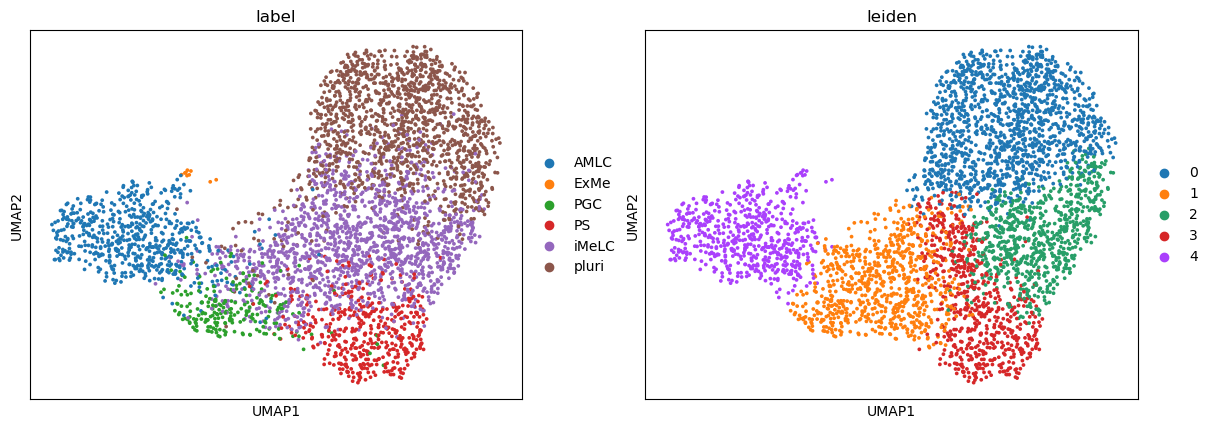

In [66]:
sc.tl.leiden(adata, resolution=0.45)
sc.pl.umap(adata,color = ["label","leiden"])

### Unwanted variation, example 2, batch effects. 

### This data is taken from [here](https://www.sciencedirect.com/science/article/pii/S2213671121001624?via%3Dihub). I saved the raw data from multiple samples from this paper in a single h5ad file

In [67]:
adata = sc.read_h5ad('data/multiBatch.h5ad')

In [69]:
adata

AnnData object with n_obs × n_vars = 14898 × 30314
    obs: 'label', 'replicate', 'time'
    var: 'ens-0-0-0-0-0', 'ens-1-0-0-0-0', 'ens-1-0-0-0', 'ens-1-0-0', 'ens-1-0', '1-1', '0-0-1', '0-1-1'

In [74]:
print(adata.obs.loc[:,"time"].unique())
print(adata.obs.loc[:,"replicate"].unique())

['0', '12', '24', '44']
Categories (4, object): ['0', '12', '24', '44']
['1', '2']
Categories (2, object): ['1', '2']


### This data is taken from 4 different time points, each has two replicate samples, and each sample has many cells. Let's use the 44h data for now. I already dropped all the cells with no label before saving, so the cells have been filtered:

In [78]:
adata = adata[adata.obs["time"]=="44"]

### Standard preprocessing and restrict to highly variable genes:

In [79]:
sc.pp.normalize_total(adata,1e4) #normalize reads per sample
sc.pp.log1p(adata) #take logarithm
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
adata = adata[:, adata.var["highly_variable"]]

In [80]:
adata

View of AnnData object with n_obs × n_vars = 2475 × 4000
    obs: 'label', 'replicate', 'time'
    var: 'ens-0-0-0-0-0', 'ens-1-0-0-0-0', 'ens-1-0-0-0', 'ens-1-0-0', 'ens-1-0', '1-1', '0-0-1', '0-1-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### Run pca, neighbors, and umap

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

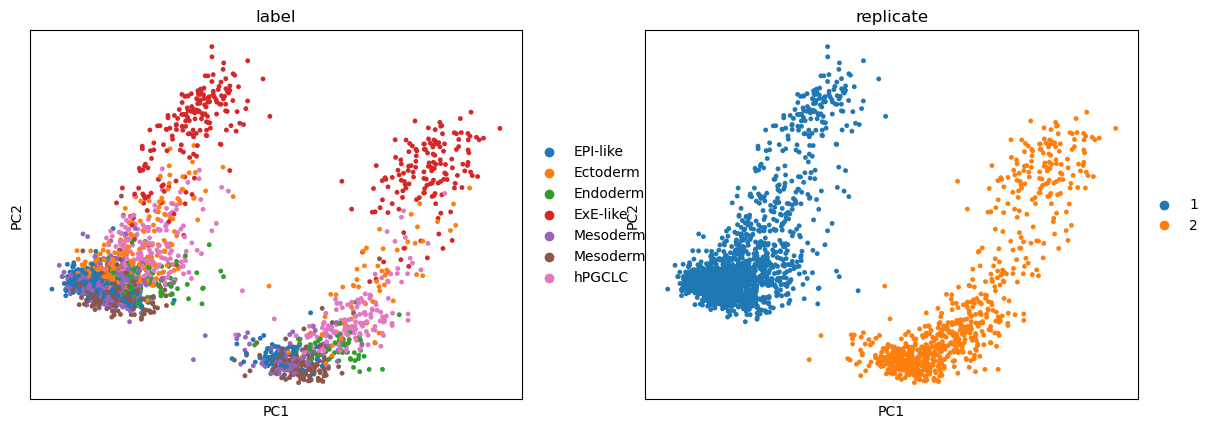

In [82]:
sc.pl.pca(adata, color = ["label","replicate"])

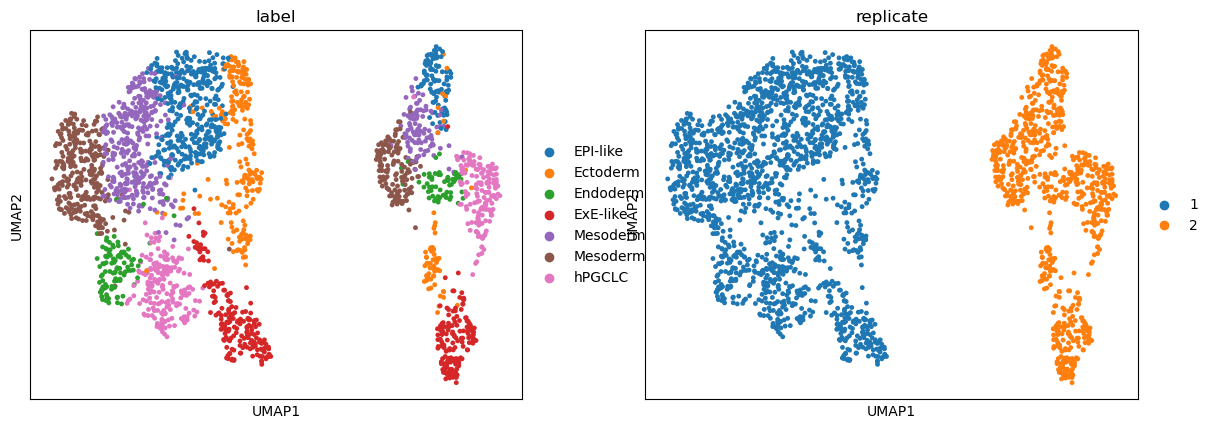

In [83]:
sc.pl.umap(adata, color = ["label","replicate"])

### It appears that the replicate is the dominant source of variation in this dataset. Let's see if we can regress it out:

In [84]:
sc.pp.regress_out(adata,"replicate")

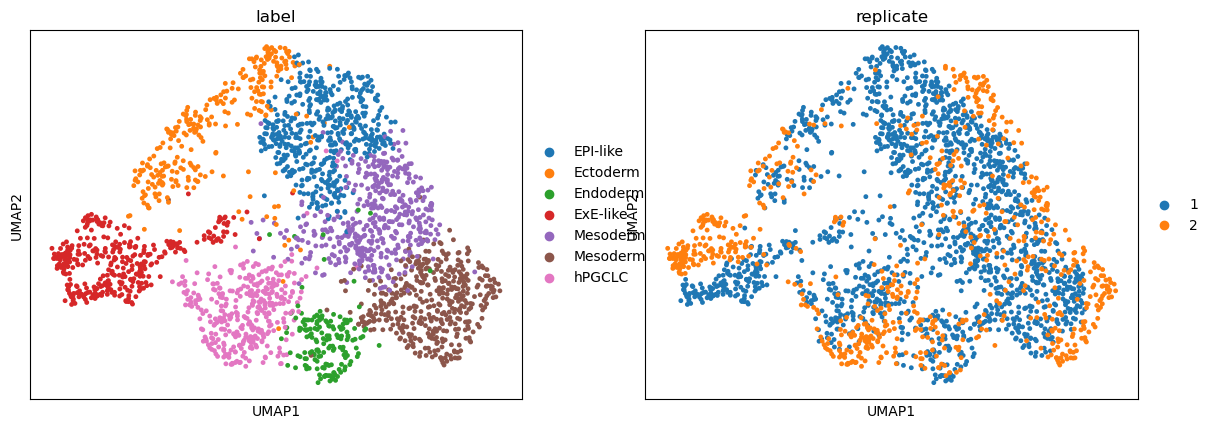

In [86]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ["label","replicate"])

### This is much better, although there is still some separation by batch, at least there is only one cluster for each cell type

### Now lets look at the full dataset:

In [87]:
adata = sc.read_h5ad('data/multiBatch.h5ad')

### Standard preprocessing and restrict to highly variable genes:

In [88]:
sc.pp.normalize_total(adata,1e4) #normalize reads per sample
sc.pp.log1p(adata) #take logarithm
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
adata = adata[:, adata.var["highly_variable"]]

### Run pca, neighbors, and umap

In [89]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

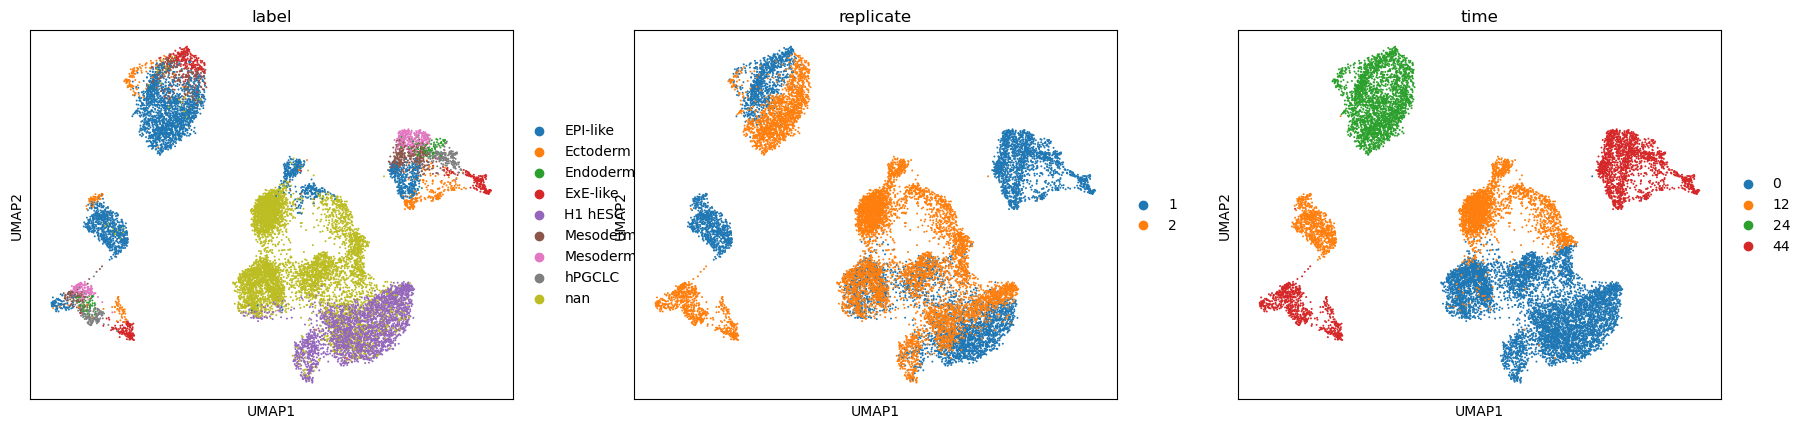

In [91]:
sc.pl.umap(adata, color = ["label","replicate","time"])

### Run the regression and repeat the analysis:

In [92]:
sc.pp.regress_out(adata,'replicate')

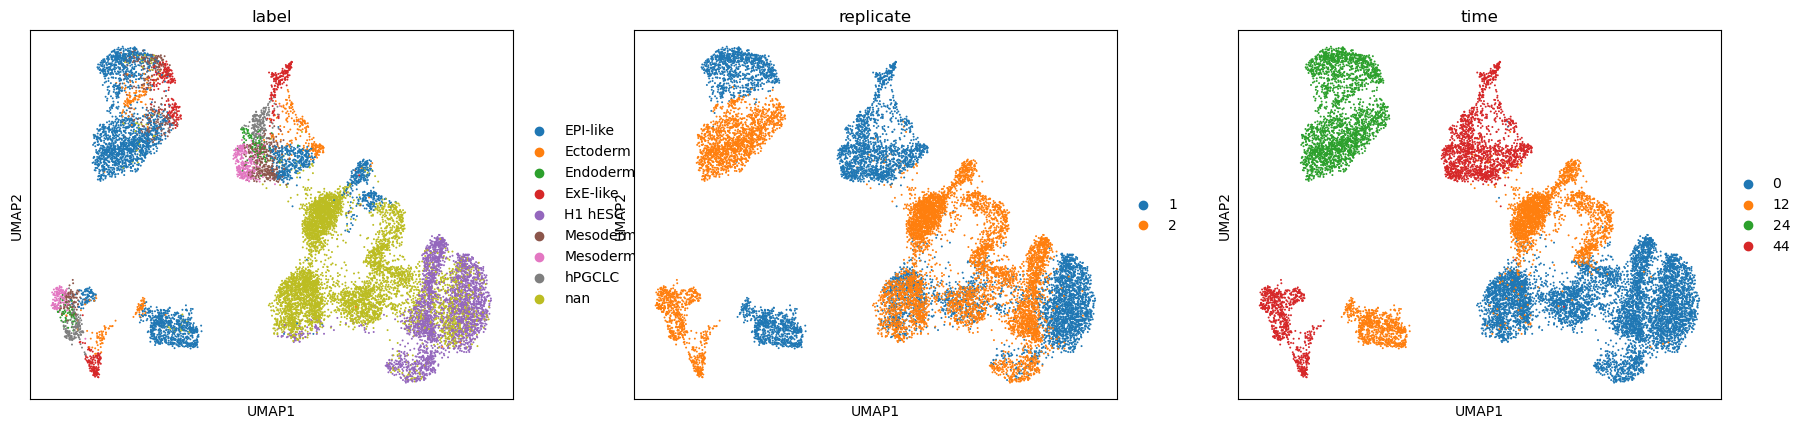

In [93]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ["label","replicate","time"])

### This didn't help much. This variability is too complex to be removed by a simple linear variation. There are tools for removing variation that essentially create a model of the data and then use this model to only keep the wanted variation. One such tool is scvi.  We will look at using scvi next time and see if it does a better job with this. In the in class assignment, you will explore a different approach using the regression function. Before next class install scvi. You will _**definitely**_ want to create a new environment for this and it may take a long time. I had better luck installing with pip than conda. You can create a new environment, activate it, and run pip to install. You may need to install pip in the new environment using "conda install pip" (before the last command here)

conda create -n bios_scvi 

conda activate bios_scvi

pip install "scvi-tools[tutorials]"

### Merging datasets:

### Two datasets can be combined with the anndata concat function:

In [94]:
data1 = sc.read_10x_h5('data/GSE182057_RAW'+'/GSM5517031_filtered_feature_bc_matrix.h5')
data1.var_names_make_unique() #make the names unique (adds "-1" or similar)

data2 = sc.read_h5ad('data/multiBatch.h5ad')

In [102]:
merge1 = data1.concatenate(data2,join="inner") #this only keeps the genes in both
merge2 = data1.concatenate(data2,join="outer") # this keep all the genes from either one
merge3 = data1.concatenate(data2) 

In [96]:
merge1

AnnData object with n_obs × n_vars = 27846 × 20022
    obs: 'label', 'replicate', 'time', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'ens-0-0-0-0-0-1', 'ens-1-0-0-0-0-1', 'ens-1-0-0-0-1', 'ens-1-0-0-1', 'ens-1-0-1', '1-1-1', '0-0-1-1', '0-1-1-1'

In [97]:
merge2

AnnData object with n_obs × n_vars = 27846 × 46893
    obs: 'label', 'replicate', 'time', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'ens-0-0-0-0-0-1', 'ens-1-0-0-0-0-1', 'ens-1-0-0-0-1', 'ens-1-0-0-1', 'ens-1-0-1', '1-1-1', '0-0-1-1', '0-1-1-1'

In [100]:
merge1.obs["time"]

AAACCCAAGAGGCGGA-1-0      NaN
AAACCCAAGCCGGATA-1-0      NaN
AAACCCAAGGGTACAC-1-0      NaN
AAACCCAAGGTGTGAC-1-0      NaN
AAACCCAAGTATTCCG-1-0      NaN
                         ... 
TTTGCGCTCCAGATCA-1-1-1     44
TTTGGTTCATATACCG-1-1-1     44
TTTGTCACACCATGTA-1-1-1     44
TTTGTCAGTGGCTCCA-1-1-1     44
TTTGTCATCACGCGGT-1-1-1     44
Name: time, Length: 27846, dtype: category
Categories (4, object): ['0', '12', '24', '44']

In [113]:
merge1.obs["replicate"]

AAACCCAAGAGGCGGA-1-0      NaN
AAACCCAAGCCGGATA-1-0      NaN
AAACCCAAGGGTACAC-1-0      NaN
AAACCCAAGGTGTGAC-1-0      NaN
AAACCCAAGTATTCCG-1-0      NaN
                         ... 
TTTGCGCTCCAGATCA-1-1-1      2
TTTGGTTCATATACCG-1-1-1      2
TTTGTCACACCATGTA-1-1-1      2
TTTGTCAGTGGCTCCA-1-1-1      2
TTTGTCATCACGCGGT-1-1-1      2
Name: replicate, Length: 27846, dtype: category
Categories (2, object): ['1', '2']

In [112]:
merge1.obs["batch"]

AAACCCAAGAGGCGGA-1-0      0
AAACCCAAGCCGGATA-1-0      0
AAACCCAAGGGTACAC-1-0      0
AAACCCAAGGTGTGAC-1-0      0
AAACCCAAGTATTCCG-1-0      0
                         ..
TTTGCGCTCCAGATCA-1-1-1    1
TTTGGTTCATATACCG-1-1-1    1
TTTGTCACACCATGTA-1-1-1    1
TTTGTCAGTGGCTCCA-1-1-1    1
TTTGTCATCACGCGGT-1-1-1    1
Name: batch, Length: 27846, dtype: category
Categories (2, object): ['0', '1']